# Studying data
The blood-brain barrier (BBB) controls the entry of chemicals from the blood to the brain. Since brain drugs need to penetrate the BBB, rapid and reliable prediction of BBB penetration (BBBP) is helpful for drug development. In this study, free-form and in-blood-form datasets were prepared by modifying the original BBBP dataset, and the effects of the data modification were investigated.

The original BBBP dataset contains 2053 items with four attributes: the index number from 1 to 2053 (“num”), the name of the compound (“name”), the penetrating or non-penetrating properties (“p_np”), and the SMILES string of the compound (“smiles”).

Sakiyama H, Fukuda M, Okuno T. Prediction of Blood-Brain Barrier Penetration (BBBP) Based on Molecular Descriptors of the Free-Form and In-Blood-Form Datasets. Molecules. 2021 Dec 7;26(24):7428. doi: 10.3390/molecules26247428. PMID: 34946509; PMCID: PMC8708321.


In [2]:
import pandas as pd

# Read in the data
drug_data=pd.read_csv("BBBP.csv")

#sum all values equal to 1 in p_np column of drug_data
total_unitary_pnp = sum(drug_data.p_np==1)
print ("Total number of unitary p_np values: ", total_unitary_pnp)

#sum all values equal to 0 in p_np column of drug_data
total_zero_pnp = sum(drug_data.p_np==0)
print ("Total number of zero p_np values: ", total_zero_pnp)

# Print the total number of p_np values
print ("Total number of p_np values: ", len(drug_data.p_np))

# Calculate the percentage of unitary p_np values
print ("Percentage of unitary p_np values: ", round(total_unitary_pnp*100/len(drug_data.p_np),2), "%")

#calculate the percentage of zero p_np values
print ("Percentage of zero p_np values: ", round (total_zero_pnp*100/len(drug_data.p_np),2), "%")


Total number of unitary p_np values:  1567
Total number of zero p_np values:  483
Total number of p_np values:  2050
Percentage of unitary p_np values:  76.44 %
Percentage of zero p_np values:  23.56 %


# Watching data in more detail to be given to GAE

The GAE should classify in two

In [3]:
from rdkit import Chem
from rdkit import RDLogger
from utils import *
from matplotlib import colors
from rdkit.Chem.Draw import MolToImage

# check the data frame
drug_data.head()

#extract smiles from the data frame and check the first 10 smiles
smiles = drug_data['smiles']
smiles.head()

#convert smiles to mols and disable warnings
RDLogger.DisableLog('rdApp.*')
mols = [Chem.MolFromSmiles(s) for s in smiles]
mols
print (type(mols[0]))

#resizing the drug_data to 
end_of_array = 20
smiles=smiles[:end_of_array]
print(smiles)

# Create a graph representation of the first molecule
for i in range(0, end_of_array):
    name = drug_data['name'][i]
    img = get_image(mols[i],None , name)

<class 'rdkit.Chem.rdchem.Mol'>
0                      [Cl].CC(C)NCC(O)COc1cccc2ccccc12
1              C(=O)(OC(C)(C)C)CCCc1ccc(cc1)N(CCCl)CCCl
2     c12c3c(N4CCN(C)CC4)c(F)cc1c(c(C(O)=O)cn2C(C)CO...
3                      C1CCN(CC1)Cc1cccc(c1)OCCCNC(=O)C
4     Cc1onc(c2ccccc2Cl)c1C(=O)N[C@H]3[C@H]4SC(C)(C)...
5     CCN1CCN(C(=O)N[C@@H](C(=O)N[C@H]2[C@H]3SCC(=C(...
6     CN(C)[C@H]1[C@@H]2C[C@H]3C(=C(O)c4c(O)cccc4[C@...
7                   Cn1c2CCC(Cn3ccnc3C)C(=O)c2c4ccccc14
8     COc1ccc(cc1)[C@@H]2Sc3ccccc3N(CCN(C)C)C(=O)[C@...
9                          NC(N)=NC(=O)c1nc(Cl)c(N)nc1N
10      OCC(C)(O)c1onc(c2ncn3c2CN(C)C(c4c3cccc4Cl)=O)n1
11        CC1=CN([C@H]2C[C@H](F)[C@@H](CO)O2)C(=O)NC1=O
12                                              C(Cl)Cl
13    C1N(C(CC2CCCCC12)C(NC(C)(C)C)=O)CC(C(Cc1ccccc1...
14               CCC(=O)C(CC(C)N(C)C)(c1ccccc1)c2ccccc2
15    CCN1N=NN(CCN2CCC(CC2)(COC)N(C(=O)CC)c3ccccc3)C1=O
16    CN(C)C(=O)C(CCN1CCC(O)(CC1)c1ccc(Cl)cc1)(c1ccc...
17              

In [6]:
from torch.utils.data import DataLoader
import networkx as nx
from torch_geometric.nn import GAE
from torch_geometric.utils import train_test_split_edges

# Load the smiles and create the graph representation
smiles = drug_data['smiles'].to_list()
# Resize the array
smiles = smiles[:end_of_array]

# Load the labels we don't want to use them for training the autoencoder
labels = drug_data['p_np'].to_list()
# Resize the array
labels = labels[:end_of_array]


# Create a list of PyTorch Geometric Data objects
data_list = create_pytorch_geometric_graph_data_list_from_smiles_and_labels(smiles, labels)
print ("First object in the data_list: " + str(data_list[0].x))

# Create a dataloader for training
dataloader = DataLoader(dataset = data_list, batch_size = 2**7)
print (dataloader)


# Define the model encoder
class GCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GCNEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels, cached=True) # cached only for transductive learning
        self.conv2 = GCNConv(2 * out_channels, out_channels, cached=True) # cached only for transductive learning

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)
    
# parameters
out_channels = 100
num_features = data_list[0].x.shape[1] #input to the encoder
print(num_features)
print("out channels: " + str(data_list[1].x.shape))
epochs = 100

# model
model = GAE(GCNEncoder(num_features, out_channels))

# move to GPU (if available)
data = data_list[0]
data = train_test_split_edges(data)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
x = data.x.to(device)

train_pos_edge_index = data.train_pos_edge_index.to(device)

# inizialize the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)



First object in the data_list: tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 1., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]])
79
out channels: torch.Size([23, 79])


In [ ]:
def train():
    model.train()
    optimizer.zero_grad()
    z = model.encode(x, train_pos_edge_index)
    loss = model.recon_loss(z, train_pos_edge_index)
    #if args.variational:
    #   loss = loss + (1 / data.num_nodes) * model.kl_loss()
    loss.backward()
    optimizer.step()
    return float(loss)


def test(pos_edge_index, neg_edge_index):
    model.eval()
    with torch.no_grad():
        z = model.encode(x, train_pos_edge_index)
    return model.test(z, pos_edge_index, neg_edge_index)

In [ ]:
for epoch in range(1, epochs + 1):
    loss = train()

    auc, ap = test(data.test_pos_edge_index, data.test_neg_edge_index)
    print('Epoch: {:03d}, AUC: {:.4f}, AP: {:.4f}'.format(epoch, auc, ap))

Epoch: 001, AUC: 1.0000, AP: 1.0000
Epoch: 002, AUC: 1.0000, AP: 1.0000
Epoch: 003, AUC: 1.0000, AP: 1.0000
Epoch: 004, AUC: 1.0000, AP: 1.0000
Epoch: 005, AUC: 1.0000, AP: 1.0000
Epoch: 006, AUC: 1.0000, AP: 1.0000
Epoch: 007, AUC: 1.0000, AP: 1.0000
Epoch: 008, AUC: 1.0000, AP: 1.0000
Epoch: 009, AUC: 1.0000, AP: 1.0000
Epoch: 010, AUC: 1.0000, AP: 1.0000
Epoch: 011, AUC: 1.0000, AP: 1.0000
Epoch: 012, AUC: 1.0000, AP: 1.0000
Epoch: 013, AUC: 1.0000, AP: 1.0000
Epoch: 014, AUC: 0.7500, AP: 0.8333
Epoch: 015, AUC: 0.7500, AP: 0.8333
Epoch: 016, AUC: 0.7500, AP: 0.8333
Epoch: 017, AUC: 0.7500, AP: 0.8333
Epoch: 018, AUC: 0.7500, AP: 0.8333
Epoch: 019, AUC: 0.7500, AP: 0.8333
Epoch: 020, AUC: 0.7500, AP: 0.8333
Epoch: 021, AUC: 0.7500, AP: 0.8333
Epoch: 022, AUC: 0.7500, AP: 0.8333
Epoch: 023, AUC: 0.7500, AP: 0.8333
Epoch: 024, AUC: 0.7500, AP: 0.8333
Epoch: 025, AUC: 0.7500, AP: 0.8333
Epoch: 026, AUC: 0.7500, AP: 0.8333
Epoch: 027, AUC: 0.7500, AP: 0.8333
Epoch: 028, AUC: 0.7500, AP:

tensor([[ 0.2145, -0.0874],
        [ 0.6251,  0.9494],
        [ 0.8111,  1.4192],
        [ 0.6251,  0.9494],
        [ 0.7493,  1.2632],
        [ 0.7917,  1.3702],
        [ 0.8571,  1.5352],
        [ 0.7268,  1.2062],
        [ 0.6662,  1.1027],
        [ 0.5125,  0.7257],
        [-0.6326, -0.9102],
        [-0.5928, -0.8716],
        [-0.7386, -1.0132],
        [-0.7062, -0.9817],
        [-0.8447, -1.1163],
        [-0.6831, -0.9592],
        [-0.7055, -0.9810],
        [-0.7461, -1.0205],
        [-0.5928, -0.8716],
        [-0.7793, -1.0527]], grad_fn=<AddBackward0>)


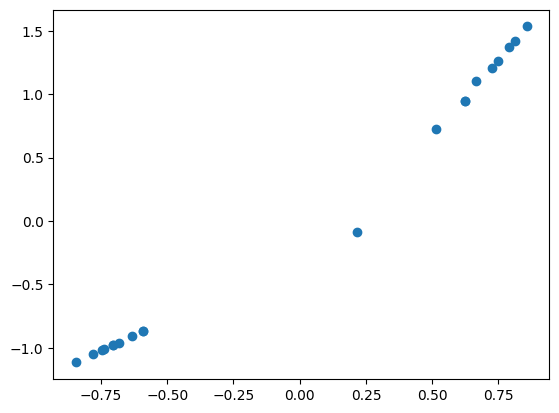

In [ ]:
import matplotlib.pyplot as plt
Z = model.encode(x, train_pos_edge_index)
print(Z)
plt.plot(Z.detach().numpy()[:,0], Z.detach().numpy()[:,1], 'o')